# **F1_DNF_ANALYSIS**

### **Intro**


- This project has the goal of idetifying whether or not an F1 car will finish a race.
- The dataset used from kaggle is: https://www.kaggle.com/datasets/pranay13257/f1-dnf-classification
- Runtime: 10 min. 
  - Meassured on Macbook Pro 2023
  - Chip: Apple M2 Pro


### **Table of contents**

**Imports**

**Useful lab methods**

**Part 1 Dataprocessing**

**Part 2 Models**
- Logistic regression
- Random Forest
- Support Vector Machine
- Neural Network

**Best Model evaluated with Test data**




## **Imports** 

In [ ]:
import random
import os

# ===============================
# Standard scientific stack
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# Scikit-learn tools
# ===============================
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import (
    precision_score,
    recall_score,
)
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold



# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras import models, layers


## **Useful lab methods**

In [33]:
def get_param_order(param_grid):
    param0 = [key for key, value in param_grid.items() if len(value) == 2]
    param1 = param_grid.keys() - param0
    return [param0[0],param1.pop()]

def unpack_gridsearch(gs):

    param_grid = gs.param_grid
    result = gs.cv_results_
    
    cols = ['mean_test_score']
        
    param_order = get_param_order(param_grid)

    f0 = 'param_{}'.format(param_order[0])
    f1 = 'param_{}'.format(param_order[1])
    f0vals = param_grid[param_order[0]]
    f1vals = param_grid[param_order[1]]
    
    X = dict.fromkeys(f0vals)

    for f0val in f0vals:
        X[f0val] = pd.DataFrame(index=f1vals,columns=cols,dtype=float)

    for f0val in f0vals:
        for f1val in f1vals:
            ind = (result[f0]==f0val) & (result[f1]==f1val)
            for col in cols:
                X[f0val].loc[f1val,col] = float(result[col][ind][0])

    return { 'scoregrid':X, 
             'best_params':gs.best_params_, 
             'best_estimator':gs.best_estimator_, 
             'best_score':gs.best_score_,
             'param_grid':param_grid
            } 

def plot_grid_result(result,log=True, baseline = None):

    param_grid = result['param_grid']
    X = result['scoregrid']
    param_order = get_param_order(param_grid)
    cols = ['mean_test_score']
    labels = [' (f1)']
    colors = ['r','b']
    linestyles = ['--', '-']

    f0vals = param_grid[param_order[0]]

    plt.figure(figsize=(10,4))
    for f0ind, f0val in enumerate(f0vals):
        for c, col in enumerate(cols):
            if log:
                plt.semilogx(X[f0val][col],color=colors[c],linestyle=linestyles[f0ind],marker='o',label='{} {}'.format(f0val,labels[c]))
            else:
                plt.plot(X[f0val][col],color=colors[c],linestyle=linestyles[f0ind],marker='o',label='{} {}'.format(f0val,labels[c]))
    if baseline is not None:
        plt.axhline(y=baseline, color='green', linestyle='-.', linewidth=2, label=f'Baseline ({baseline:.4f})')
    plt.legend(fontsize=12)
    plt.grid(':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def hypersolve(model,param_grid, X_train, y_train):
    pipe = Pipeline([
        ('model', model)
    ])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid, 
        scoring='f1', 
        cv=3, 
        refit='f1'
    )
    
    gs = gs.fit(X_train, y_train)
    result = unpack_gridsearch(gs)
    plot_grid_result(result)
    return result

## **Part 1 Dataprocessing**

#### Loading data and prining out head & shape ###

In [34]:
#Importing data to dataframe
raw_data = pd.read_csv('data.csv')
print(raw_data.head().to_string())
print("Shape: ", raw_data.shape)

   resultId  raceId  year  round  grid  positionOrder  points  laps milliseconds fastestLap rank fastestLapTime fastestLapSpeed        driverRef     surname forename         dob nationality_x constructorRef                          name nationality_y     circuitRef  circuitId        name_y    location  country      lat        lng  alt        date  target_finish
0      2460     136  2002     13    11              4     3.0  77.0          NaN         \N   \N             \N              \N        raikkonen   Räikkönen     Kimi  1979-10-17       Finnish        mclaren                   Hungaroring       British    hungaroring         11       McLaren    Budapest  Hungary  47.5789   19.24860  264  2002-08-18              1
1     11565     483  1981      1    23             21     0.0  16.0           \N         \N   \N             \N              \N           watson      Watson     John  1946-05-04       British        mclaren                    Long Beach       British     long_beach       

#### Print overview of columns containing NA values, and drop those containing over 10%. ###

In [35]:
# Make sure other types of missing data is also registered as missing data
missing_markers = ['\\N', 'NULL', 'null', ''] 
raw_data = raw_data.replace(missing_markers, np.nan)

nullValues = raw_data.isnull().sum()
print("Rows with NA and NA count: ")
print(nullValues[nullValues > 0])
print("\nShape with 90% threshold for dropping column:")
thresh = round(0.9*raw_data.shape[0])
trimmed_raw_data = raw_data.dropna(axis=1, thresh=thresh)
print(trimmed_raw_data.shape)
print(trimmed_raw_data.columns)

Rows with NA and NA count: 
points              971
laps                978
milliseconds       7393
fastestLap         6895
rank               6798
fastestLapTime     6895
fastestLapSpeed    7191
dtype: int64

Shape with 90% threshold for dropping column:
(10000, 26)
Index(['resultId', 'raceId', 'year', 'round', 'grid', 'positionOrder',
       'points', 'laps', 'driverRef', 'surname', 'forename', 'dob',
       'nationality_x', 'constructorRef', 'name', 'nationality_y',
       'circuitRef', 'circuitId', 'name_y', 'location', 'country', 'lat',
       'lng', 'alt', 'date', 'target_finish'],
      dtype='object')


### Further feature selection ###
Some columns have leakage features, meaning they have a 1-1 correlation with what we try to predict.These need to be removed as they will make the predictions too "easy". Some of these are also measurements made after after the target value is measured, and therefore don't have any predictive power. E.g. "positionOrder" and "points", which are based upon whether the driver finishes the race or not. <br>

Will keep features 'year', 'round', 'grid', 'constructorRef', 'circuitRef', 'alt', 'date' as well as 'target_finish' <br>
Reasons one by one: <br><br>

##### Id's #####
- resultId: DROP – not useful

- raceId: DROP – not useful

- circuitId: DROP – Redundant with circuitRef

##### Race metadata #####

- year: KEEP – DNF rates may vary over the years

- round: KEEP – Early/late season influences DNF

- date: KEEP – Weather/season patterns

- country: DROP - redundant with circuitRef

##### Driver & team #####

- driverRef: DROP - High cardinality, too sparse. Data of retired drivers unuseful for future drivers

- surname: DROP – same reason as driverRef

- forename: DROP – same reason as driverRef

- dob: DROP – weak predictor

- nationality_x: DROP – Weak predictor

- constructorRef: KEEP – Team strongly impacts DNF

- nationality_y: DROP – irrelevant / redundant to constructorRef

##### Performance stats #####

- grid: KEEP – Starting position affects crash risk

- positionOrder: DROP – Leakage (reveals final result)

##### Circuit info #####

- circuitRef: KEEP – Tracks differ in DNF probability

- name: DROP – Duplicate of circuitRef

- name_y: DROP – Another duplicate

- location: DROP – Text field, not useful

##### Geographical #####

- lat: DROP – Raw coordinate not meaningful

- lng: DROP – Same as above

- alt: KEEP - altitude of tracks may be predicitive  

target_finish: KEEP - Need this for training


Since we are removing points and laps, due to leakage, alle columns that cointains NA values are removed.

In [36]:
keep_cols = [
    'year', 'round', 'grid', 'constructorRef',
    'circuitRef', 'alt', 'date',
    'target_finish'
]
clean_data = trimmed_raw_data[keep_cols].copy()
print("Shape:", clean_data.shape)
print("Features:",clean_data.columns)

Shape: (10000, 8)
Features: Index(['year', 'round', 'grid', 'constructorRef', 'circuitRef', 'alt', 'date',
       'target_finish'],
      dtype='object')


#### Printing out describtion of dataframe, and ranked correlation between numerical features for analysis ###

In [37]:
print(clean_data.describe().to_string())
print("\nCorrelation between numerical features and target_finish ranked on abs value")
print(clean_data.corr(numeric_only=True)['target_finish'].sort_values(key=abs, ascending=False)[1:])

               year         round          grid           alt  target_finish
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000
mean    1991.466600      8.540100     11.176200    281.465900       0.289500
std       20.060237      5.085487      7.241008    414.586363       0.453553
min     1950.000000      1.000000      0.000000     -7.000000       0.000000
25%     1977.000000      4.000000      5.000000     18.000000       0.000000
50%     1991.000000      8.000000     11.000000    153.000000       0.000000
75%     2009.000000     12.000000     17.000000    401.000000       1.000000
max     2024.000000     24.000000     34.000000   2227.000000       1.000000

Correlation between numerical features and target_finish ranked on abs value
grid    -0.344964
year     0.276936
round    0.123115
alt     -0.043222
Name: target_finish, dtype: float64


#### Handling 'object' values ###

Will use a reduced One Hot Encoding. Let the top 10 most common values per feature be one hot encoded, place all other values under a group called 'other...'

Then convert date to month, and OHE it

In [38]:
clean_data["date"] = pd.to_datetime(clean_data["date"]).dt.month
clean_data = clean_data.rename(columns={"date":"month"})

In [39]:
top_10_constructorRefs = clean_data['constructorRef'].value_counts().nlargest(10).index

print("The Top 10 constructorRefs are:", list(top_10_constructorRefs))

# Replace country if not in top 10 with 'Other'
clean_data['constructorRef'] = clean_data['constructorRef'].apply(
    lambda x: x if x in top_10_constructorRefs else 'other_const'
)

The Top 10 constructorRefs are: ['ferrari', 'mclaren', 'williams', 'sauber', 'team_lotus', 'tyrrell', 'red_bull', 'renault', 'ligier', 'brabham']


In [40]:
top_10_circuitRef = clean_data['circuitRef'].value_counts().nlargest(10).index

print("The Top 10 circuitRef are:", list(top_10_circuitRef))

# Replace country if not in top 10 with 'Other'
clean_data['circuitRef'] = clean_data['circuitRef'].apply(
    lambda x: x if x in top_10_circuitRef else 'other_circ'
)

The Top 10 circuitRef are: ['monza', 'monaco', 'silverstone', 'spa', 'villeneuve', 'hungaroring', 'nurburgring', 'hockenheimring', 'interlagos', 'red_bull_ring']


#### Dataset before OHE 

In [41]:
print(clean_data.head().to_string())

   year  round  grid constructorRef     circuitRef  alt  month  target_finish
0  2002     13    11        mclaren    hungaroring  264      8              1
1  1981      1    23        mclaren     other_circ   12      3              0
2  1958      8     0    other_const    nurburgring  578      8              0
3  2021      8    19    other_const  red_bull_ring  678      6              0
4  1988     12     0    other_const          monza  162      9              0


In [42]:
cat = ["constructorRef", "circuitRef", "month"]
enc = OneHotEncoder()
enc.fit(clean_data[cat])
cat_data = enc.transform(clean_data[cat]).toarray()

cat_df = pd.DataFrame(data = cat_data, columns = enc.get_feature_names_out(), index = clean_data.index)
encoded_data = clean_data.join(cat_df).drop(columns = cat)

# Dropped to avoid linear dependencies 
encoded_data = encoded_data.drop(columns=["circuitRef_other_circ", "constructorRef_other_const", "month_12"])

#### Dataset after OHE 

In [43]:
print(encoded_data.head().to_string())
print(encoded_data.shape)
print(encoded_data.columns)

   year  round  grid  alt  target_finish  constructorRef_brabham  constructorRef_ferrari  constructorRef_ligier  constructorRef_mclaren  constructorRef_red_bull  constructorRef_renault  constructorRef_sauber  constructorRef_team_lotus  constructorRef_tyrrell  constructorRef_williams  circuitRef_hockenheimring  circuitRef_hungaroring  circuitRef_interlagos  circuitRef_monaco  circuitRef_monza  circuitRef_nurburgring  circuitRef_red_bull_ring  circuitRef_silverstone  circuitRef_spa  circuitRef_villeneuve  month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11
0  2002     13    11  264              1                     0.0                     0.0                    0.0                     1.0                      0.0                     0.0                    0.0                        0.0                     0.0                      0.0                        0.0                     1.0                    0.0                0.0               

#### Flip values in target_finish 
We want to detect DNF, make this our positive

In [44]:
encoded_data['target_dnf'] = 1 - encoded_data['target_finish']
encoded_data = encoded_data.drop(columns=["target_finish"])
print(encoded_data["target_dnf"].value_counts())

target_dnf
1    7105
0    2895
Name: count, dtype: int64


#### Data split 

cutoff_year set to 2015 arbitrarily for now. Can change this, but gives a reasonable split (test size ~15% of dataset)

In [45]:
cutoff_year = 2015

train_data = encoded_data[encoded_data['year'] <= cutoff_year].copy()
test_data  = encoded_data[encoded_data['year'] >  cutoff_year].copy()

X_train = train_data.drop(columns=['target_dnf'])
y_train = train_data['target_dnf']

X_test  = test_data.drop(columns=['target_dnf'])
y_test  = test_data['target_dnf']

print("Training size (X, y):", X_train.shape, ",", len(y_train))
print("Test size (X, y):", X_test.shape, ",", len(y_test))

Training size (X, y): (8550, 35) , 8550
Test size (X, y): (1450, 35) , 1450


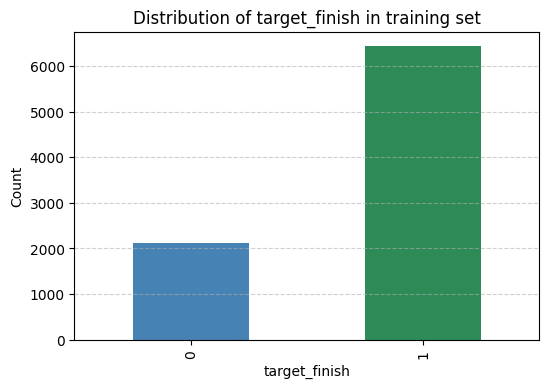

In [ ]:
# Count target_dnf distribution in training data
counts = train_data['target_dnf'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'seagreen'])

plt.title("Distribution of target_dnf in training set")
plt.xlabel("target_dnf")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

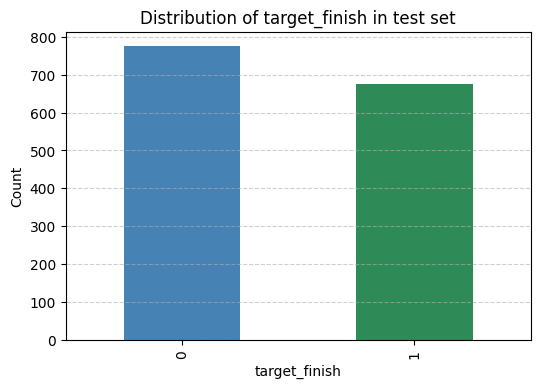

In [ ]:
# Count target_dnf distribution in test data
counts = test_data['target_dnf'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'seagreen'])

plt.title("Distribution of target_dnf in test set")
plt.xlabel("target_dnf")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

As we can see above, the whole trainingset is not balanced. There are generally more dnf´s before 2015, than after 2015, making our predictions less reliable, as things has gotten safer. Our testset however, is balanced, which is a good thing.

## **Part 2Models**

### **Logistic regression**

Beginning of logistic regression
Starting with finding strong features using Lasso

In [48]:
random_seed = 2334

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

feature_extractor = LogisticRegression(penalty='l1', solver='liblinear', random_state=random_seed, C=1)

feature_extractor.fit(X_train_scaled, y_train)

#Threshold 0.05, this gives 19 features with C=1
thresh = 0.05

significant = X_train.columns[abs(feature_extractor.coef_[0])>thresh]
coefficients = feature_extractor.coef_[0][abs(feature_extractor.coef_[0])>thresh]
z = list(zip(significant, coefficients))
z.sort(key=lambda x: abs(x[1]), reverse=True)
significantSorted = [p[0] for p in z]

X_train_lasso = X_train[significant]
X_test_lasso = X_test[significant]

After Lasso has had its way with our features, we are left with 19 features.
We will then test out different subsets of these in conjunction with changing the levels of regularization. 
To do this we will create a pipeline and use a Grid search

What happens in the following cell
1. We define a list of lists of features. These are selected based on the output of the previous cell, where lasso assigns higher coefficients to features with more predictive power. We try all the significant ones, the best half, the best quarter, worst best eight and then only one feature.
2. We define a parametergrid, currently the only parameter is C, which is the amount of lasso-regularization. 
3. We iterate through the different subsets of features, and do gridsearch, with a cv of 5, for each one of them. 
4. We save the best result of each feature-set

['grid', 'year', 'constructorRef_ferrari', 'constructorRef_mclaren', 'constructorRef_williams', 'circuitRef_nurburgring', 'constructorRef_red_bull', 'circuitRef_monaco', 'constructorRef_ligier', 'month_10', 'constructorRef_renault', 'constructorRef_team_lotus', 'circuitRef_spa', 'circuitRef_interlagos', 'alt', 'constructorRef_tyrrell', 'month_3', 'circuitRef_silverstone', 'circuitRef_villeneuve']
Baseline f1-score is: 0.8584779706275033
Model: Feature_Set_1_(1 columns)


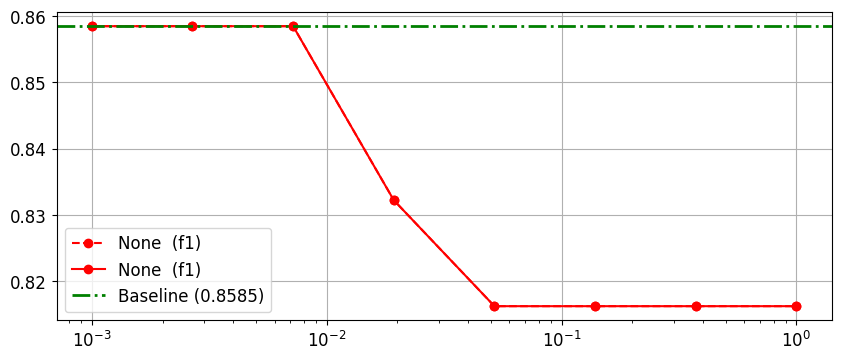

Model: Feature_Set_2_(2 columns)


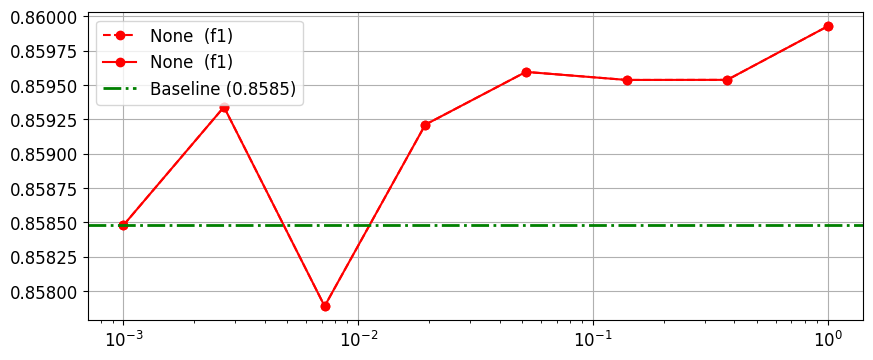

Model: Feature_Set_3_(4 columns)


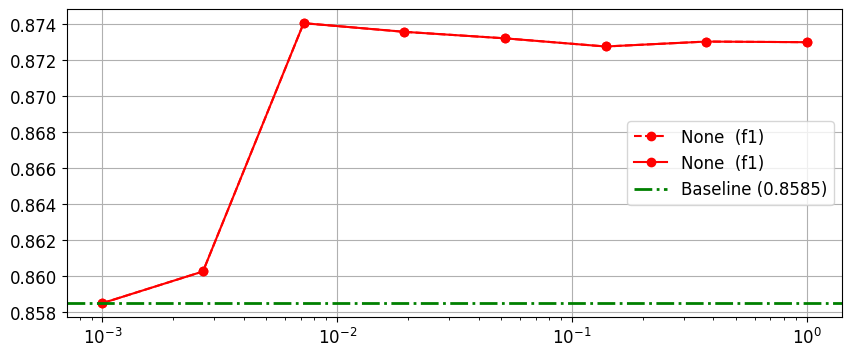

Model: Feature_Set_4_(9 columns)


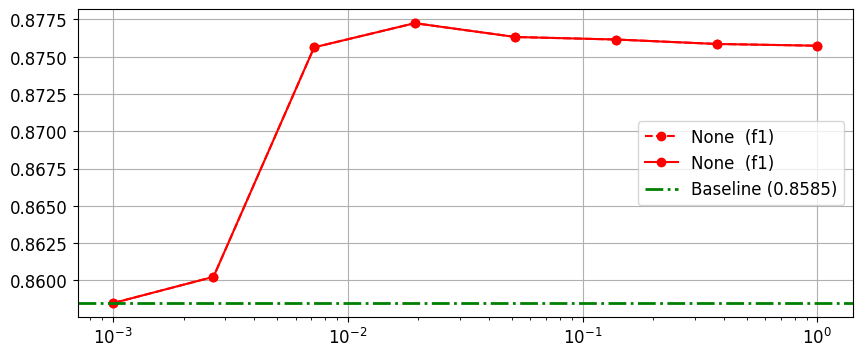

Model: Feature_Set_5_(19 columns)


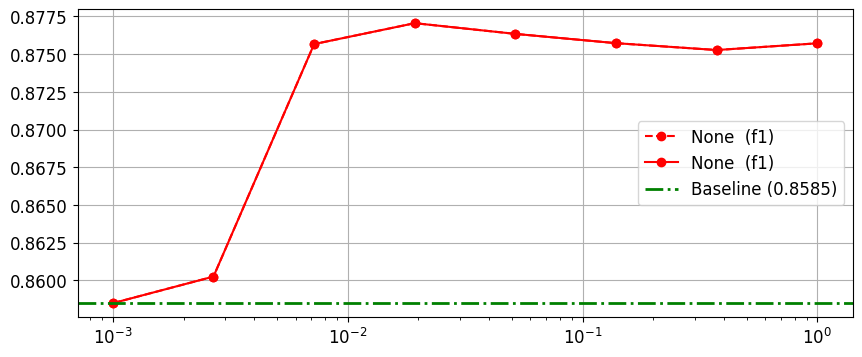

**Feature_Set_1_(1 columns)**: Training F1 = 0.8585, Validation F1 = 0.8585, Best C = 0.0010
**Feature_Set_2_(2 columns)**: Training F1 = 0.8596, Validation F1 = 0.8599, Best C = 1.0000
**Feature_Set_3_(4 columns)**: Training F1 = 0.8746, Validation F1 = 0.8741, Best C = 0.0072
**Feature_Set_4_(9 columns)**: Training F1 = 0.8768, Validation F1 = 0.8772, Best C = 0.0193
**Feature_Set_5_(19 columns)**: Training F1 = 0.8780, Validation F1 = 0.8771, Best C = 0.0193


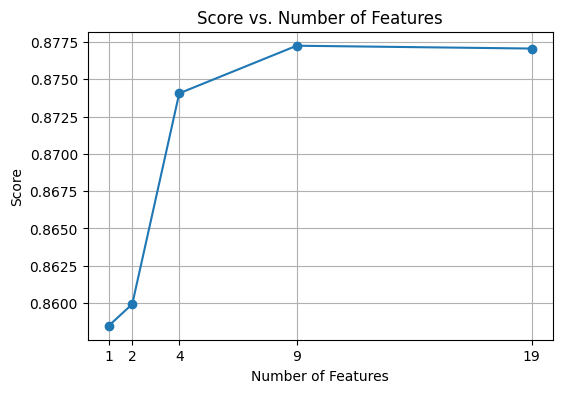

In [49]:
print(significantSorted)

#We try all the features, the best half and quarter, as well as the worst half for fun
listsOfFeatures = [
    significantSorted[0:len(significantSorted)//16],
    significantSorted[0:len(significantSorted)//8],
    significantSorted[0:len(significantSorted)//4],
    significantSorted[0:len(significantSorted)//2],
    significantSorted,
]

param_grid = {
    'model__C' : np.logspace(-3, 0, 8),
    'model__class_weight': [None, None], #added this workaround to reuse lab-function for visualizing
}


pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(solver='liblinear', penalty='l1', random_state=random_seed))
])


results = {}
scores = []

#Finding baseline
baseLinePredictions = np.ones_like(y_train)
f1Baseline = f1_score(baseLinePredictions, y_train)
print(f"Baseline f1-score is: {f1Baseline}")


for i, features in enumerate(listsOfFeatures):
   X_train_iter = X_train[features]
   grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1')
   key = f"Feature_Set_{i+1}_({len(features)} columns)"
   grid.fit(X_train_iter, y_train)

   print(F"Model: {key}")

   logreg_result = unpack_gridsearch(grid)
   plot_grid_result(logreg_result, baseline=f1Baseline)

   best_model = grid.best_estimator_

   y_train_pred = best_model.predict(X_train_iter)

   training_f1 = f1_score(y_train, y_train_pred)

   

   #Storing results
   results[key] = {
       'model_family': 'LogisticRegression',
       'num_features': len(features),
       'training_f1': training_f1,
       'validation_f1': grid.best_score_,
       'best_c': grid.best_params_['model__C'],
       'best_params': grid.best_params_,
       'features_used': features
   }
   scores.append((grid.best_score_, len(features)))

for key, res in results.items():
   print(f"**{key}**: Training F1 = {res['training_f1']:.4f}, Validation F1 = {res['validation_f1']:.4f}, Best C = {res['best_c']:.4f}")

#logic to plot how validation scores go as the number of features used varies
score_values = [s for s, n in scores]
feature_counts = [n for s, n in scores]

plt.figure(figsize=(6,4))
plt.plot(feature_counts, score_values, marker='o')

plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Score vs. Number of Features")

plt.xticks(feature_counts)    # force integer ticks on the x-axis
plt.grid(True)
plt.show()

### **Random Forest**

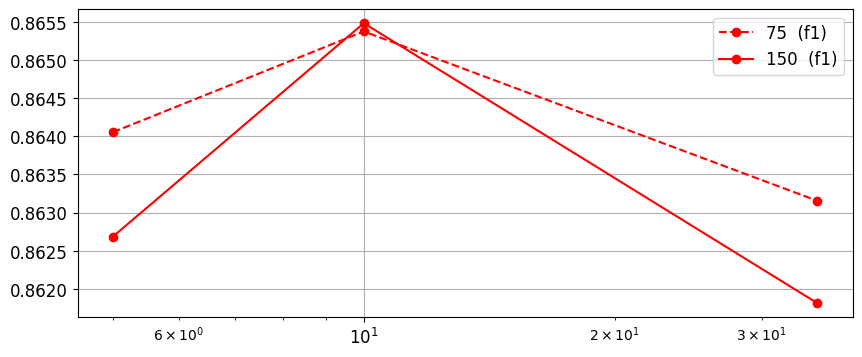


max_depth = None
Best F1 for depth None : 0.8654826129007777
Best params: {'model__max_features': 10, 'model__n_estimators': 150}


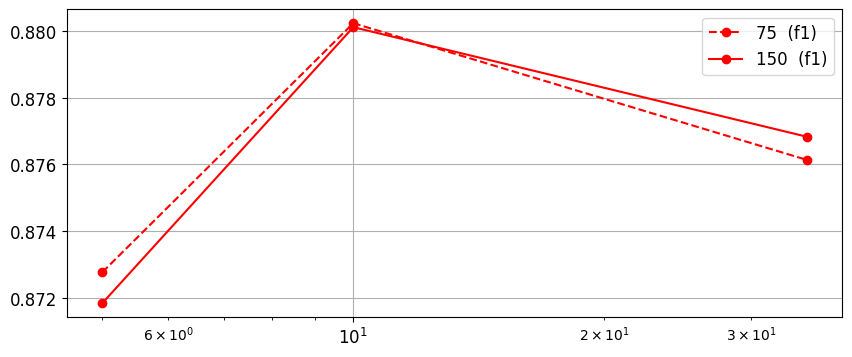


max_depth = 5
Best F1 for depth 5 : 0.8802409117327322
Best params: {'model__max_features': 10, 'model__n_estimators': 75}


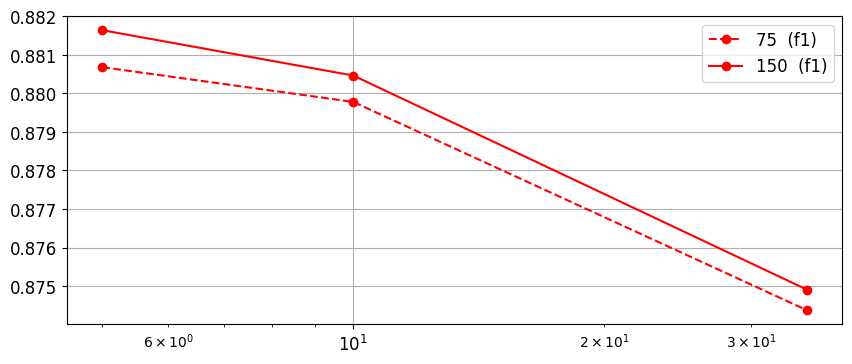


max_depth = 10
Best F1 for depth 10 : 0.8816430896251033
Best params: {'model__max_features': 5, 'model__n_estimators': 150}

Best model: depth = 10 , n_estimators = 150 , max_features = 5 
Best F1 score for 3-fold CV: 0.8816430896251033 
important features (>= 0.01):
 grid                       0.400102
year                       0.223756
round                      0.054677
constructorRef_ferrari     0.052743
constructorRef_mclaren     0.051206
alt                        0.048774
constructorRef_williams    0.042652
constructorRef_red_bull    0.020156
dtype: float64

Training F1 score: 0.9041808072785039


In [50]:
rng_seed = 42

param_grid_rf = {
    'model__n_estimators': [75, 150],
    'model__max_features': [5, 10, X_train.shape[1]],
}

depths = [None, 5, 10]

results_by_depth = {}

for d in depths:
    
    model = RandomForestClassifier(random_state=rng_seed, max_depth=d)
    
    result_rf = hypersolve(model, param_grid_rf, X_train, y_train)
    
    best_params = result_rf['best_params']
    best_score  = result_rf['best_score']
    print("\nmax_depth =", d)
    print("Best F1 for depth", d, ":", best_score)
    print("Best params:", best_params)
    
    results_by_depth[d] = result_rf

best_depth = max(results_by_depth, key=lambda d: results_by_depth[d]['best_score'])
best_result = results_by_depth[best_depth]
best_rf = best_result['best_estimator'].named_steps['model']
best_params = best_result['best_params']
best_score = best_result['best_score']

feature_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
important_features_rf = feature_importance[feature_importance >= 0.01]

print("\nBest model: depth =", best_depth, 
      ", n_estimators =", best_params["model__n_estimators"], 
      ", max_features =", best_params["model__max_features"], 
      "\nBest F1 score for 3-fold CV:", best_score, 
      "\nimportant features (>= 0.01):\n", important_features_rf
)
print("\nTraining F1 score:", f1_score(best_rf.predict(X_train), y_train))

In [51]:
# New design matrix defined by feature importance for potensial use in other models
X_train_RF = train_data[important_features_rf.index]

## **Support Vector Machine**

### SVM Baseline Model

As a starting point, we train a simple SVM on the preprocessed dataset:

- We build a `Pipeline` with:
  - `StandardScaler` to normalise features,
  - `SVC` with default hyperparameters.
- We evaluate this baseline using **5-fold cross-validation on the training set only**, with F1 (DNF = 1) as the scoring metric.
- We report the mean and standard deviation of the CV F1 scores.

This gives us a reference point for later hyperparameter tuning and feature variations.




In [52]:
RANDOM_STATE = 42

svm_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=RANDOM_STATE))
])

baseline_cv_scores = cross_val_score(
    svm_baseline, X_train, y_train, scoring="f1", cv=5, n_jobs=-1
)

print("Baseline SVM (preprocessed) CV F1:")
print(f"  mean = {baseline_cv_scores.mean():.4f}, std = {baseline_cv_scores.std():.4f}")

Baseline SVM (preprocessed) CV F1:
  mean = 0.8683, std = 0.0057


### SVM Hyperparameter Search (Grid Search)

We now perform a grid search to tune the SVM on the preprocessed dataset:

- The model is the same SVM pipeline (scaler + `SVC`).
- We vary only **model-related hyperparameters**:
  - `C ∈ {0.1, 1, 10}` (regularisation strength),
  - `γ ∈ {"scale", 0.1, 0.01}` (kernel coefficient for RBF/poly),
  - `kernel ∈ {"linear", "rbf", "poly"}`.
- We use `GridSearchCV` with 5-fold cross-validation and F1 (DNF = 1) as the metric.
- From this we obtain:
  - the best hyperparameter combination,
  - and the corresponding **validation F1**.

In [53]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=RANDOM_STATE))
])

svm_param_grid = {
    "model__kernel": ["linear", "rbf", "poly"],
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.1, 0.01],
}

svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=svm_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
)

svm_grid.fit(X_train, y_train)

print("Best params from grid search:")
print(svm_grid.best_params_)
print(f"Best CV F1: {svm_grid.best_score_:.4f}")

Best params from grid search:
{'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Best CV F1: 0.8711


### SVM on Feature-Selected Dataset
In addition to the preprocessed dataset, we also train SVMs on a **feature-selected dataset**:

- The feature-selected matrix comes from earlier work (Random Forest importance or L1-regularised logistic regression).
- We align these columns with the same training rows (years ≤ 2015) to build `X_train_fs` and `y_train_fs`.
- We first evaluate a baseline SVM pipeline (scaler + default `SVC`) via 5-fold CV.
- Then we run **another grid search with the same hyperparameter grid** as before (`C`, `γ`, kernel).
- We record the best hyperparameters and their validation F1.

Comparing the CV results on the preprocessed vs feature-selected datasets shows whether reducing the feature space hurts, helps, or leaves SVM performance essentially unchanged.

In [54]:
rf_feature_cols = important_features_rf.index.tolist()

X_train_fs = train_data[rf_feature_cols]
y_train_fs = train_data["target_dnf"]

print("Feature-selected SVM training size (X, y):", X_train_fs.shape, ",", len(y_train_fs))

print("\nChecking that targets are not in X columns (feature-selected):")
for col in ["target_finish", "target_dnf"]:
    print(f"{col} in X_train_fs? {col in X_train_fs.columns}")

svm_baseline_fs = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=RANDOM_STATE)),
])
baseline_fs_cv = cross_val_score(
    svm_baseline_fs, X_train_fs, y_train_fs, scoring="f1", cv=5, n_jobs=-1
)
print("\nBaseline SVM (feature-selected) CV F1:")
print(f"  mean = {baseline_fs_cv.mean():.4f}, std = {baseline_fs_cv.std():.4f}")

svm_pipe_fs = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=RANDOM_STATE)),
])

svm_grid_fs = GridSearchCV(
    estimator=svm_pipe_fs,
    param_grid=svm_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
)

svm_grid_fs.fit(X_train_fs, y_train_fs)

print("\nBest params from grid search (feature-selected):")
print(svm_grid_fs.best_params_)
print(f"Best CV F1 (feature-selected): {svm_grid_fs.best_score_:.4f}")

Feature-selected SVM training size (X, y): (8550, 8) , 8550

Checking that targets are not in X columns (feature-selected):
target_finish in X_train_fs? False
target_dnf in X_train_fs? False

Baseline SVM (feature-selected) CV F1:
  mean = 0.8764, std = 0.0038

Best params from grid search (feature-selected):
{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best CV F1 (feature-selected): 0.8780


### Top-K SVM Models

Instead of only inspecting the single best SVM configuration, we also look at the **top-K** (here, K = 10) hyperparameter settings from the grid search:

- We use the `cv_results_` from `GridSearchCV` and sort them by mean validation F1.
- For the top-K entries, we extract:
  - the hyperparameter combination (`C`, `γ`, and kernel),
  - the mean and standard deviation of the validation F1,
  - and the mean training F1.

This analysis helps us see whether several configurations perform similarly well, and how sensitive performance is to the choice of hyperparameters.

,rank,params,cv_mean_f1,cv_std_f1,cv_mean_train_f1
0,1,"{'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}",0.871087,0.005852,0.885143
1,2,"{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}",0.870956,0.004408,0.894459
2,3,"{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.868662,0.005802,0.885092
3,4,"{'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'poly'}",0.868447,0.003263,0.883420
4,5,"{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}",0.868260,0.005652,0.881758
5,6,"{'model__C': 1, 'model__gamma': 0.01, 'model__kernel': 'rbf'}",0.868021,0.004663,0.875884
6,7,"{'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'poly'}",0.867790,0.003505,0.892684
7,8,"{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.867469,0.003387,0.897066
8,9,"{'model__C': 1, 'model__gamma': 0.01, 'model__kernel': 'linear'}",0.866381,0.003473,0.867091
9,10,"{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}",0.866381,0.003473,0.867091


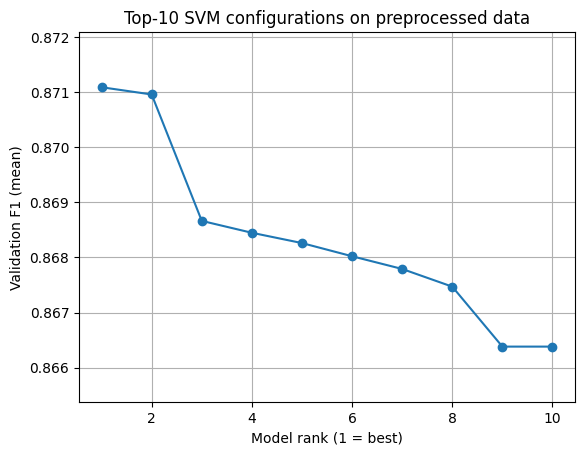

In [55]:
TOP_K = 10

cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results_sorted = cv_results.sort_values(
    by="mean_test_score", ascending=False
).reset_index(drop=True)

top_k_rows = cv_results_sorted.head(TOP_K)

topk_records = []
for idx, row in top_k_rows.iterrows():
    topk_records.append({
        "rank": idx + 1,
        "params": row["params"],
        "cv_mean_f1": row["mean_test_score"],
        "cv_std_f1": row["std_test_score"],
        "cv_mean_train_f1": row["mean_train_score"],
    })

topk_df = pd.DataFrame(topk_records)
pd.set_option("display.max_colwidth", None)
display(topk_df)

plt.figure()
plt.plot(topk_df["rank"], topk_df["cv_mean_f1"], marker="o")
plt.xlabel("Model rank (1 = best)")
plt.ylabel("Validation F1 (mean)")
plt.title("Top-10 SVM configurations on preprocessed data")

# Optional: zoom the y-axis to make differences easier to see
y_min = topk_df["cv_mean_f1"].min() - 0.001
y_max = topk_df["cv_mean_f1"].max() + 0.001
plt.ylim(y_min, y_max)

plt.grid(True)
plt.show()

### SVM Feature Subset Experiments
Using the best SVM hyperparameters from the grid search, we examine how performance changes when we restrict the model to fewer input features:

- On the training data, we compute the absolute Pearson correlation between each numeric feature and the label `target_dnf`.
- Based on this ranking, we define four feature sets:
  - `all_features`: all preprocessed features,
  - `top_15_corr`: 15 most strongly correlated features,
  - `top_10_corr`: 10 most strongly correlated features,
  - `top_5_corr`: 5 most strongly correlated features.
- For each feature set, we:
  - train the SVM with the same best hyperparameters,
  - evaluate it using 5-fold cross-validation on the training set,
  - and record the mean and standard deviation of CV F1.

This tells us whether a smaller, more compact feature set can achieve similar performance, which is relevant for interpretability and data collection in a real F1 setting.


Best SVM params (preprocessed): {'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}

Top 15 features by |correlation with target_dnf| (training):
grid                       0.329577
year                       0.201510
constructorRef_ferrari     0.182564
constructorRef_mclaren     0.166749
constructorRef_williams    0.154116
constructorRef_red_bull    0.120927
round                      0.089674
constructorRef_ligier      0.070423
constructorRef_renault     0.061068
circuitRef_nurburgring     0.040516
circuitRef_monaco          0.040062
constructorRef_brabham     0.039531
month_10                   0.039272
constructorRef_tyrrell     0.038831
month_5                    0.038004
Name: target_dnf, dtype: float64

=== CV for best SVM on all_features (35 features) ===

=== CV for best SVM on top_15_corr (15 features) ===

=== CV for best SVM on top_10_corr (10 features) ===

=== CV for best SVM on top_5_corr (5 features) ===


,features,n_features,cv_mean_f1,cv_std_f1
0,all_features,35,0.871087,0.005852
1,top_15_corr,15,0.873845,0.005004
2,top_10_corr,10,0.875887,0.004934
3,top_5_corr,5,0.869078,0.003443


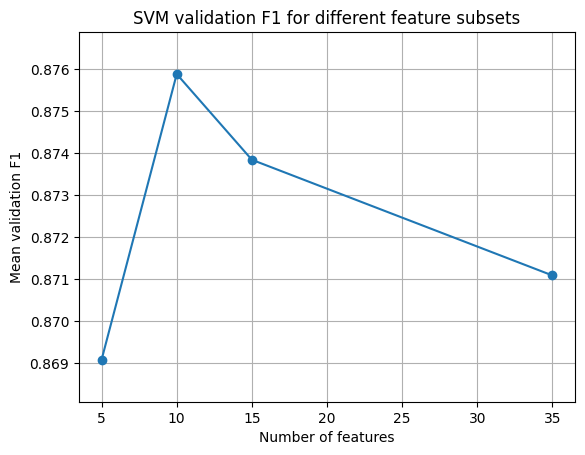

In [56]:
best_params = svm_grid.best_params_
print("Best SVM params (preprocessed):", best_params)

corr = train_data.corr(numeric_only=True)["target_dnf"].abs().sort_values(ascending=False)
corr = corr.drop(labels=["target_dnf", "target_finish"], errors="ignore")

print("\nTop 15 features by |correlation with target_dnf| (training):")
print(corr.head(15))

feature_sets = {
    "all_features": X_train.columns.tolist(),
    "top_15_corr": corr.head(15).index.tolist(),
    "top_10_corr": corr.head(10).index.tolist(),
    "top_5_corr":  corr.head(5).index.tolist(),
}

subset_records = []

for name, cols in feature_sets.items():
    print(f"\n=== CV for best SVM on {name} ({len(cols)} features) ===")
    X_train_sub = X_train[cols]

    svm_best = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(random_state=RANDOM_STATE)),
    ])
    svm_best.set_params(**best_params)

    cv_scores = cross_val_score(
        svm_best, X_train_sub, y_train, scoring="f1", cv=5, n_jobs=-1
    )

    subset_records.append({
        "features": name,
        "n_features": len(cols),
        "cv_mean_f1": cv_scores.mean(),
        "cv_std_f1": cv_scores.std(),
    })

subset_results_df = pd.DataFrame(subset_records)
display(subset_results_df)

plt.figure()
plt.plot(subset_results_df["n_features"],
         subset_results_df["cv_mean_f1"],
         marker="o")
plt.xlabel("Number of features")
plt.ylabel("Mean validation F1")
plt.title("SVM validation F1 for different feature subsets")
y_min = subset_results_df["cv_mean_f1"].min() - 0.001
y_max = subset_results_df["cv_mean_f1"].max() + 0.001
plt.ylim(y_min, y_max)

plt.grid(True)
plt.show()

## Training and Validation F1 for Preprocessed and Feature-Selected Data

Finally, we summarise the cross-validated performance of the **best SVM model on each dataset**:

- For the **preprocessed dataset**, we extract:
  - mean training F1,
  - mean validation F1 of the best SVM from the grid search.
- For the **feature-selected dataset**, we do the same using `svm_grid_fs`.

In [57]:
best_idx_pre = svm_grid.best_index_
train_f1_pre = svm_grid.cv_results_["mean_train_score"][best_idx_pre]
val_f1_pre   = svm_grid.best_score_

print("Preprocessed SVM:")
print(f"  Training F1   = {train_f1_pre:.4f}")
print(f"  Validation F1 = {val_f1_pre:.4f}")

best_idx_fs = svm_grid_fs.best_index_
train_f1_fs = svm_grid_fs.cv_results_["mean_train_score"][best_idx_fs]
val_f1_fs   = svm_grid_fs.best_score_

print("\nFeature-selected SVM:")
print(f"  Training F1   = {train_f1_fs:.4f}")
print(f"  Validation F1 = {val_f1_fs:.4f}")


Preprocessed SVM:
  Training F1   = 0.8851
  Validation F1 = 0.8711

Feature-selected SVM:
  Training F1   = 0.8848
  Validation F1 = 0.8780


### **Neural Network**

#### **Intro**

In this part of the project, we focus on Neural Networks. Broadly, neural network architectures can be divided into four major families: MLPs, RNNs, CNNs, and Transformers. Each of these architectures is designed to handle different data structures. Since our dataset does not contain sequential or spatial structure, there is no temporal dependency or context from one row to the next.

Because of this, architectures that rely on such structure, RNNs (designed for sequence modeling), CNNs (designed for spatial patterns), and Transformers (designed for long-range contextual dependencies) are not suitable here. Instead, MLPs (Multi-Layer Perceptrons) are the most appropriate choice, as they perform best on tabular, independent samples where each row is treated as a standalone input.

Tunable Parameters:

- `depth` 
    - A higher depth lets the model capture more abstract features, but if it becomes too deep, it may start fitting noise rather than meaningful structure.
- `droput` 
    - Randomly deactivates a fraction of neurons during training. This prevents the network from relying too heavily on specific nodes and helps reduce overfitting by encouraging more robust feature learning.
- `activation`
    - Activation determines which non-linear function is applied to a layer’s weighted inputs. Without activation functions, the network would behave like a linear model and be unable to learn complex representations.
- `l2_reg` 
    - Introduces a penalty term equal to the sum of squared weights. This pushes the model toward smaller, more evenly distributed weights and improves generalization.”

In [58]:

#========================
# RANDOM SEEDS FOR REPRODUCIBILITY
#========================

SEED = 67

#We need the GPU and weight upperations to be deterministic as well
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.config.experimental.enable_op_determinism()


# ========================================================
# PARAMETER GRID 32 models
# ========================================================

param_grid = {
    "depth": [
    [128, 64],
    [256, 128, 64],
    [512, 256, 128, 64, 32]
    ],


    "dropout": [0.0,0.2, 0.05],  


    "activation": [
        tf.keras.activations.relu,
    ],


    "l2_reg": [0.0001, 0.001, 0.0],  
}


# ========================================================
# BUILD MODEL
# ========================================================

# Dimensionality of input data
input_dim = X_train.shape[1]



#MLP builder for grid search
def build_mlp(hidden_layers, activation, dropout, l2_reg):

    #Create an MLP model
    model = models.Sequential()
    #Add input layer
    model.add(layers.Input(shape=(input_dim,)))

    #Iterate over hidden layers in depth config
    for h in hidden_layers:
        model.add(layers.Dense(
            h,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.Dropout(dropout))

    #Output layer, Sigmoid for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile model, using Adam optimizer and binary crossentropy loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


# ========================================================
# UPDATED GRID SEARCH WITH K-FOLD CV
# ========================================================

results = []
best_model = None
best_val_f1 = -1
model_id = 1

EPOCHS = 5
BATCH = 32


K = 3
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

for depth in param_grid["depth"]:
    for dropout in param_grid["dropout"]:
        for activation in param_grid["activation"]:
            for l2_reg in param_grid["l2_reg"]:
                
                print(f"\n=== MODEL {model_id} ===")
                print(f"Depth:      {depth}")
                print(f"Dropout:    {dropout}")
                print(f"Activation: {activation.__name__}")
                print(f"L2:         {l2_reg}")

                #Scores per fold for averaging later
                fold_train_f1_scores = []
                fold_train_loss_scores = []
                fold_val_f1_scores = []
                fold_val_loss_scores = []

                # Curves per fold for averaging later
                train_loss_curves = []
                val_loss_curves = []
                train_acc_curves = []
                val_acc_curves = []

                # ======== K-FOLD LOOP ========
                for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
                    print(f"  Fold {fold+1}/{K}")

                    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                    # Build new model
                    model = build_mlp(depth, activation, dropout, l2_reg)

                    # Train WITH validation data
                    history = model.fit(
                        X_tr, y_tr,
                        validation_data=(X_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH,
                        verbose=0
                    )

                    # Final metrics
                    train_pred = (model.predict(X_tr, verbose=0) > 0.5).astype(int)
                    val_pred   = (model.predict(X_val, verbose=0) > 0.5).astype(int)

                    train_f1 = f1_score(y_tr, train_pred)
                    val_f1   = f1_score(y_val, val_pred)

                    fold_train_f1_scores.append(train_f1)
                    fold_val_f1_scores.append(val_f1)

                    train_loss = history.history["loss"][-1]
                    val_loss   = history.history["val_loss"][-1]

                    fold_train_loss_scores.append(train_loss)
                    fold_val_loss_scores.append(val_loss)

                    print(f"     Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

                    # Store curves for averaging
                    train_loss_curves.append(history.history["loss"])
                    val_loss_curves.append(history.history["val_loss"])
                    train_acc_curves.append(history.history["accuracy"])
                    val_acc_curves.append(history.history["val_accuracy"])

                # ======== CV AVERAGES ========

                train_f1_mean = np.mean(fold_train_f1_scores)
                val_f1_mean   = np.mean(fold_val_f1_scores)

                train_loss_mean = np.mean(fold_train_loss_scores)
                val_loss_mean   = np.mean(fold_val_loss_scores)

                # FINAL PLOT CURVES - average over folds
                avg_train_loss_curve = np.mean(train_loss_curves, axis=0)
                avg_val_loss_curve   = np.mean(val_loss_curves, axis=0)
                avg_train_acc_curve  = np.mean(train_acc_curves, axis=0)
                avg_val_acc_curve    = np.mean(val_acc_curves, axis=0)

                print(f" → Mean Train F1: {train_f1_mean:.4f}")
                print(f" → Mean Train Loss: {train_loss_mean:.4f}")
                print(f" → Mean Val F1:   {val_f1_mean:.4f}")
                print(f" → Mean Val Loss: {val_loss_mean:.4f}")

                # ===== STORE ONLY WHAT YOU NEED FOR PLOTTING =====
                results.append({
                    "model_id": model_id,
                    "depth": depth,
                    "dropout": dropout,
                    "activation": activation.__name__,
                    "l2_reg": l2_reg,

                    # summary metrics
                    "train_f1_mean": train_f1_mean,
                    "train_loss_mean": train_loss_mean,
                    "val_f1_mean": val_f1_mean,
                    "val_loss_mean": val_loss_mean,

                    # Curves fom history:
                    "avg_train_loss_curve": avg_train_loss_curve,
                    "avg_val_loss_curve": avg_val_loss_curve,
                    "avg_train_acc_curve": avg_train_acc_curve,
                    "avg_val_acc_curve": avg_val_acc_curve,
                })

                # BEST MODEL SELECTION
                if val_f1_mean > best_val_f1:
                    best_val_f1 = val_f1_mean
                    best_model = build_mlp(depth, activation, dropout, l2_reg)
                    best_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)


                                

                model_id += 1

print("\n===================================")
print(" BEST MEAN CV F1:", best_val_f1)
print("===================================")


=== MODEL 1 ===
Depth:      [128, 64]
Dropout:    0.0
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:11:56.466339: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-10 22:12:02.267943: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

     Train F1: 0.6246 | Val F1: 0.6366
  Fold 2/3
     Train F1: 0.5870 | Val F1: 0.5759
  Fold 3/3


2025-12-10 22:12:08.075330: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8575 | Val F1: 0.8573
 → Mean Train F1: 0.6897
 → Mean Train Loss: 0.5025
 → Mean Val F1:   0.6899
 → Mean Val Loss: 0.6756

=== MODEL 2 ===
Depth:      [128, 64]
Dropout:    0.0
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:12:14.501229: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8628 | Val F1: 0.8629
  Fold 2/3
     Train F1: 0.8457 | Val F1: 0.8407
  Fold 3/3


2025-12-10 22:12:19.590181: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8204 | Val F1: 0.8168
 → Mean Train F1: 0.8430
 → Mean Train Loss: 0.6099
 → Mean Val F1:   0.8401
 → Mean Val Loss: 0.6217

=== MODEL 3 ===
Depth:      [128, 64]
Dropout:    0.0
Activation: relu
L2:         0.0
  Fold 1/3


2025-12-10 22:12:26.114596: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7589 | Val F1: 0.7635
  Fold 2/3


2025-12-10 22:12:31.435041: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7343 | Val F1: 0.7310
  Fold 3/3


2025-12-10 22:12:36.594728: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8534 | Val F1: 0.8592
 → Mean Train F1: 0.7822
 → Mean Train Loss: 0.5109
 → Mean Val F1:   0.7846
 → Mean Val Loss: 0.5738

=== MODEL 4 ===
Depth:      [128, 64]
Dropout:    0.2
Activation: relu
L2:         0.0001
  Fold 1/3
     Train F1: 0.8713 | Val F1: 0.8713
  Fold 2/3


2025-12-10 22:12:42.482746: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8716 | Val F1: 0.8707
  Fold 3/3


2025-12-10 22:12:47.653385: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8194 | Val F1: 0.8123
 → Mean Train F1: 0.8541
 → Mean Train Loss: 0.5818
 → Mean Val F1:   0.8514
 → Mean Val Loss: 0.5640

=== MODEL 5 ===
Depth:      [128, 64]
Dropout:    0.2
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:12:53.223799: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8662 | Val F1: 0.8649
  Fold 2/3


2025-12-10 22:12:58.255082: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.6377 | Val F1: 0.6335
  Fold 3/3
     Train F1: 0.8033 | Val F1: 0.8018
 → Mean Train F1: 0.7691
 → Mean Train Loss: 0.6884
 → Mean Val F1:   0.7667
 → Mean Val Loss: 0.7040

=== MODEL 6 ===
Depth:      [128, 64]
Dropout:    0.2
Activation: relu
L2:         0.0
  Fold 1/3


2025-12-10 22:13:04.291980: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8602 | Val F1: 0.8605
  Fold 2/3


2025-12-10 22:13:09.302484: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8585 | Val F1: 0.8584
  Fold 3/3
     Train F1: 0.7919 | Val F1: 0.7794
 → Mean Train F1: 0.8369
 → Mean Train Loss: 0.5502
 → Mean Val F1:   0.8327
 → Mean Val Loss: 0.5392

=== MODEL 7 ===
Depth:      [128, 64]
Dropout:    0.05
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:13:15.090761: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8626 | Val F1: 0.8610
  Fold 2/3


2025-12-10 22:13:20.199374: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8379 | Val F1: 0.8351
  Fold 3/3
     Train F1: 0.7458 | Val F1: 0.7430
 → Mean Train F1: 0.8154
 → Mean Train Loss: 0.5500
 → Mean Val F1:   0.8130
 → Mean Val Loss: 0.5699

=== MODEL 8 ===
Depth:      [128, 64]
Dropout:    0.05
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:13:25.924350: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8413 | Val F1: 0.8437
  Fold 2/3


2025-12-10 22:13:30.976883: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.7940 | Val F1: 0.7854
  Fold 3/3


2025-12-10 22:13:36.878020: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.7391 | Val F1: 0.7358
 → Mean Train F1: 0.7915
 → Mean Train Loss: 0.6426
 → Mean Val F1:   0.7883
 → Mean Val Loss: 0.6832

=== MODEL 9 ===
Depth:      [128, 64]
Dropout:    0.05
Activation: relu
L2:         0.0
  Fold 1/3
     Train F1: 0.6274 | Val F1: 0.6560
  Fold 2/3


2025-12-10 22:13:43.106761: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.5863 | Val F1: 0.5641
  Fold 3/3


2025-12-10 22:13:48.319363: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8661 | Val F1: 0.8651
 → Mean Train F1: 0.6933
 → Mean Train Loss: 0.5206
 → Mean Val F1:   0.6950
 → Mean Val Loss: 0.6516

=== MODEL 10 ===
Depth:      [256, 128, 64]
Dropout:    0.0
Activation: relu
L2:         0.0001
  Fold 1/3
     Train F1: 0.8632 | Val F1: 0.8627
  Fold 2/3


2025-12-10 22:13:55.448052: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8723 | Val F1: 0.8714
  Fold 3/3


2025-12-10 22:14:00.531339: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8456 | Val F1: 0.8444
 → Mean Train F1: 0.8604
 → Mean Train Loss: 0.4992
 → Mean Val F1:   0.8595
 → Mean Val Loss: 0.5127

=== MODEL 11 ===
Depth:      [256, 128, 64]
Dropout:    0.0
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:14:06.844295: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8358 | Val F1: 0.8382
  Fold 2/3


2025-12-10 22:14:13.791361: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8702 | Val F1: 0.8700
  Fold 3/3


2025-12-10 22:14:20.253602: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8493 | Val F1: 0.8535
 → Mean Train F1: 0.8518
 → Mean Train Loss: 0.7489
 → Mean Val F1:   0.8539
 → Mean Val Loss: 0.7725

=== MODEL 12 ===
Depth:      [256, 128, 64]
Dropout:    0.0
Activation: relu
L2:         0.0
  Fold 1/3
     Train F1: 0.8238 | Val F1: 0.8303
  Fold 2/3


2025-12-10 22:14:27.578916: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7753 | Val F1: 0.7652
  Fold 3/3


2025-12-10 22:14:33.515119: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8562 | Val F1: 0.8571
 → Mean Train F1: 0.8184
 → Mean Train Loss: 0.4554
 → Mean Val F1:   0.8176
 → Mean Val Loss: 0.5377

=== MODEL 13 ===
Depth:      [256, 128, 64]
Dropout:    0.2
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:14:38.638629: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8675 | Val F1: 0.8705
  Fold 2/3
     Train F1: 0.8338 | Val F1: 0.8290
  Fold 3/3


2025-12-10 22:14:43.739206: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8181 | Val F1: 0.8153
 → Mean Train F1: 0.8398
 → Mean Train Loss: 0.6120
 → Mean Val F1:   0.8383
 → Mean Val Loss: 0.5687

=== MODEL 14 ===
Depth:      [256, 128, 64]
Dropout:    0.2
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:14:51.265261: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7910 | Val F1: 0.7959
  Fold 2/3


2025-12-10 22:14:57.720823: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.7591 | Val F1: 0.7551
  Fold 3/3


2025-12-10 22:15:02.764964: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.6504 | Val F1: 0.6332
 → Mean Train F1: 0.7335
 → Mean Train Loss: 0.8535
 → Mean Val F1:   0.7281
 → Mean Val Loss: 0.8938

=== MODEL 15 ===
Depth:      [256, 128, 64]
Dropout:    0.2
Activation: relu
L2:         0.0
  Fold 1/3
     Train F1: 0.8594 | Val F1: 0.8591
  Fold 2/3


2025-12-10 22:15:10.233906: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8338 | Val F1: 0.8298
  Fold 3/3


2025-12-10 22:15:15.903500: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8081 | Val F1: 0.8099
 → Mean Train F1: 0.8338
 → Mean Train Loss: 0.5365
 → Mean Val F1:   0.8329
 → Mean Val Loss: 0.5277

=== MODEL 16 ===
Depth:      [256, 128, 64]
Dropout:    0.05
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:15:24.577501: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7855 | Val F1: 0.7881
  Fold 2/3


2025-12-10 22:15:29.876726: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8491 | Val F1: 0.8491
  Fold 3/3


2025-12-10 22:15:34.951795: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8632 | Val F1: 0.8589
 → Mean Train F1: 0.8326
 → Mean Train Loss: 0.5182
 → Mean Val F1:   0.8321
 → Mean Val Loss: 0.5383

=== MODEL 17 ===
Depth:      [256, 128, 64]
Dropout:    0.05
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:15:41.414768: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8636 | Val F1: 0.8644
  Fold 2/3


2025-12-10 22:15:46.425216: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8756 | Val F1: 0.8707
  Fold 3/3
     Train F1: 0.8476 | Val F1: 0.8446
 → Mean Train F1: 0.8623
 → Mean Train Loss: 0.7706
 → Mean Val F1:   0.8599
 → Mean Val Loss: 0.7682

=== MODEL 18 ===
Depth:      [256, 128, 64]
Dropout:    0.05
Activation: relu
L2:         0.0
  Fold 1/3


2025-12-10 22:15:55.595637: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7368 | Val F1: 0.7421
  Fold 2/3


2025-12-10 22:16:03.030350: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8647 | Val F1: 0.8597
  Fold 3/3


2025-12-10 22:16:09.376639: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8628 | Val F1: 0.8589
 → Mean Train F1: 0.8214
 → Mean Train Loss: 0.5022
 → Mean Val F1:   0.8202
 → Mean Val Loss: 0.5304

=== MODEL 19 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.0
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:16:16.360979: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8747 | Val F1: 0.8737
  Fold 2/3


2025-12-10 22:16:23.561054: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8634 | Val F1: 0.8545
  Fold 3/3


2025-12-10 22:16:30.680878: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8642 | Val F1: 0.8652
 → Mean Train F1: 0.8674
 → Mean Train Loss: 0.5314
 → Mean Val F1:   0.8645
 → Mean Val Loss: 0.5666

=== MODEL 20 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.0
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:16:38.364813: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-10 22:16:44.924411: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

     Train F1: 0.8319 | Val F1: 0.8292
  Fold 2/3


2025-12-10 22:16:52.702860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8684 | Val F1: 0.8669
  Fold 3/3


2025-12-10 22:16:59.872647: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8608 | Val F1: 0.8619
 → Mean Train F1: 0.8537
 → Mean Train Loss: 1.1285
 → Mean Val F1:   0.8527
 → Mean Val Loss: 1.1541

=== MODEL 21 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.0
Activation: relu
L2:         0.0
  Fold 1/3


2025-12-10 22:17:06.923589: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.7987 | Val F1: 0.7975
  Fold 2/3


2025-12-10 22:17:14.412917: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8758 | Val F1: 0.8732
  Fold 3/3


2025-12-10 22:17:21.794547: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


     Train F1: 0.8446 | Val F1: 0.8434
 → Mean Train F1: 0.8397
 → Mean Train Loss: 0.4837
 → Mean Val F1:   0.8381
 → Mean Val Loss: 0.5280

=== MODEL 22 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.2
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:17:27.174176: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8648 | Val F1: 0.8608
  Fold 2/3


2025-12-10 22:17:38.742311: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7117 | Val F1: 0.7027
  Fold 3/3


2025-12-10 22:17:46.866925: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7902 | Val F1: 0.7780
 → Mean Train F1: 0.7889
 → Mean Train Loss: 0.6525
 → Mean Val F1:   0.7805
 → Mean Val Loss: 0.6408

=== MODEL 23 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.2
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:17:54.875470: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.6693 | Val F1: 0.6933
  Fold 2/3


2025-12-10 22:18:03.310584: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8455 | Val F1: 0.8468
  Fold 3/3


2025-12-10 22:18:11.660386: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8561 | Val F1: 0.8496
 → Mean Train F1: 0.7903
 → Mean Train Loss: 1.2705
 → Mean Val F1:   0.7966
 → Mean Val Loss: 1.2307

=== MODEL 24 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.2
Activation: relu
L2:         0.0
  Fold 1/3


2025-12-10 22:18:19.350348: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8432 | Val F1: 0.8455
  Fold 2/3


2025-12-10 22:18:27.855669: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7486 | Val F1: 0.7352
  Fold 3/3


2025-12-10 22:18:36.448698: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8647 | Val F1: 0.8655
 → Mean Train F1: 0.8188
 → Mean Train Loss: 0.6270
 → Mean Val F1:   0.8154
 → Mean Val Loss: 0.5778

=== MODEL 25 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.05
Activation: relu
L2:         0.0001
  Fold 1/3


2025-12-10 22:18:44.948240: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8696 | Val F1: 0.8732
  Fold 2/3


2025-12-10 22:18:52.898004: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7994 | Val F1: 0.7954
  Fold 3/3


2025-12-10 22:19:01.570637: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8339 | Val F1: 0.8252
 → Mean Train F1: 0.8343
 → Mean Train Loss: 0.6024
 → Mean Val F1:   0.8313
 → Mean Val Loss: 0.5982

=== MODEL 26 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.05
Activation: relu
L2:         0.001
  Fold 1/3


2025-12-10 22:19:09.965037: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7581 | Val F1: 0.7696
  Fold 2/3


2025-12-10 22:19:18.051387: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8600 | Val F1: 0.8578
  Fold 3/3


2025-12-10 22:19:26.194216: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7656 | Val F1: 0.7582
 → Mean Train F1: 0.7946
 → Mean Train Loss: 1.1651
 → Mean Val F1:   0.7952
 → Mean Val Loss: 1.2309

=== MODEL 27 ===
Depth:      [512, 256, 128, 64, 32]
Dropout:    0.05
Activation: relu
L2:         0.0
  Fold 1/3


2025-12-10 22:19:34.385557: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.7891 | Val F1: 0.7959
  Fold 2/3


2025-12-10 22:19:42.472869: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8503 | Val F1: 0.8453
  Fold 3/3


2025-12-10 22:19:50.759836: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


     Train F1: 0.8695 | Val F1: 0.8634
 → Mean Train F1: 0.8363
 → Mean Train Loss: 0.5460
 → Mean Val F1:   0.8349
 → Mean Val Loss: 0.5376

 BEST MEAN CV F1: 0.8644661430969577


In [59]:

# SORT AND PRINT RESULTS

results_sorted = sorted(results, key=lambda x: x["val_f1_mean"], reverse=True)

print("\n===============================")
print(" TOP MODELS")
print("===============================\n")

for r in results_sorted[:4]:
    print(f"Model {r['model_id']} — f1_val_score={r['val_f1_mean']:.4f}, f1_train_score={r['train_f1_mean']:.4f}")
    print(f"  depth={r['depth']}")
    print(f"  dropout={r['dropout']}")
    print(f"  activation={r['activation']}")
    print(f"  L2={r['l2_reg']}")
    print("---------------------------------")



 TOP MODELS

Model 19 — f1_val_score=0.8645, f1_train_score=0.8674
  depth=[512, 256, 128, 64, 32]
  dropout=0.0
  activation=relu
  L2=0.0001
---------------------------------
Model 17 — f1_val_score=0.8599, f1_train_score=0.8623
  depth=[256, 128, 64]
  dropout=0.05
  activation=relu
  L2=0.001
---------------------------------
Model 10 — f1_val_score=0.8595, f1_train_score=0.8604
  depth=[256, 128, 64]
  dropout=0.0
  activation=relu
  L2=0.0001
---------------------------------
Model 11 — f1_val_score=0.8539, f1_train_score=0.8518
  depth=[256, 128, 64]
  dropout=0.0
  activation=relu
  L2=0.001
---------------------------------


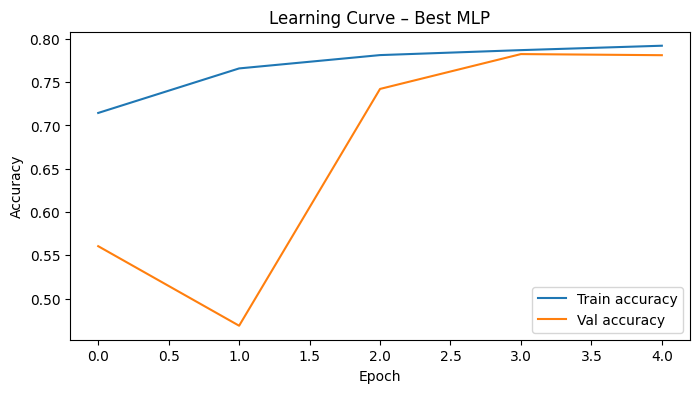

In [60]:
best = results_sorted[0]

plt.figure(figsize=(8,4))
plt.plot(best["avg_train_acc_curve"], label="Train accuracy")
plt.plot(best["avg_val_acc_curve"], label="Val accuracy")    
plt.title("Learning Curve – Best MLP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()





The plot shows that the train and validation accuracy curves converge nicely, indicating that the model is learning effectively without significant overfitting. The gap between the two curves is relatively small, suggesting good generalization to unseen data and no overfitting

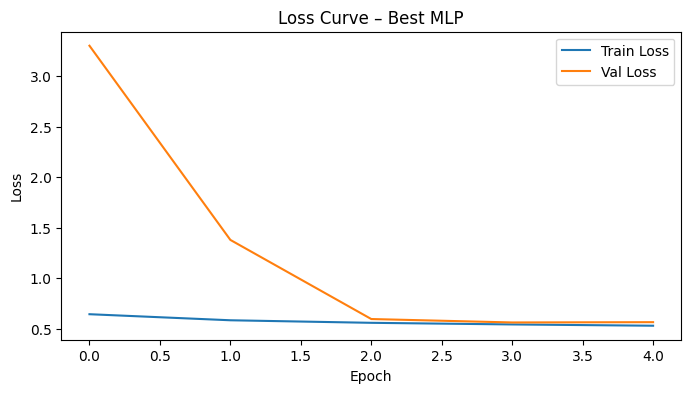

In [61]:
best = results_sorted[0]

plt.figure(figsize=(8,4))
plt.plot(best["avg_train_loss_curve"], label="Train Loss")
plt.plot(best["avg_val_loss_curve"], label="Val Loss")
plt.title("Loss Curve – Best MLP")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss curves show a consistent downward trend for both the training and validation sets, indicating that the model continues to learn throughout the training process. Although the validation loss fluctuates slightly from epoch to epoch, this is expected given the relatively small validation set and the fixed optimizer settings required by the project. Overall, the training and validation loss follow similar trajectories, suggesting that the model generalizes reasonably well without severe overfitting.

# Best Model evaluated with Test data - Random Forest

In [62]:
y_test_hat = best_rf.predict(X_test)
print("F1:",f1_score(y_test_hat, y_test))
print("Recall:", recall_score(y_test_hat, y_test))
print("Precision:", precision_score(y_test_hat, y_test))

F1: 0.7040328092959672
Recall: 0.6535532994923858
Precision: 0.762962962962963
